<a href="https://colab.research.google.com/github/MuxtorovAbubakr/MachineLearningProjects/blob/main/Logistic_Regression_Social_Network_Ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression with polynomials and normalization

## Setup and Imports

This section imports the necessary libraries for data manipulation, plotting, and machine learning model building. We'll be using `numpy` for numerical operations, `matplotlib.pyplot` for visualization, and `sklearn.model_selection` for splitting the data.

In [1038]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Data Loading

Here, we load the dataset from a CSV file into a `numpy` array. The dataset contains information about social network users, including their age, estimated salary, and whether they purchased a particular product. We skip the header row during loading.

In [1039]:
dataset = np.loadtxt('/content/sample_data/kaggle datasets/Social_Network_Ads.csv', delimiter=',', skiprows=1)

## Configure Print Options

We set `numpy`'s print options to suppress scientific notation for smaller numbers, making the array output more readable.

In [1040]:
np.set_printoptions(suppress=True)

## Data Inspection

Let's display the first few rows of the loaded dataset to understand its structure and content.

In [1041]:
print(dataset)

[[   19. 19000.     0.]
 [   35. 20000.     0.]
 [   26. 43000.     0.]
 ...
 [   50. 20000.     1.]
 [   36. 33000.     0.]
 [   49. 36000.     1.]]


We check the shape of the dataset to see the number of rows (samples) and columns (features).

In [1042]:
print(dataset.shape)

(400, 3)


## Feature and Target Split

We separate the dataset into features (`X`) and the target variable (`y`).
*   `X` will contain the independent variables (Age and Estimated Salary).
*   `y` will contain the dependent variable (Purchased, where 0 means No and 1 means Yes).

In [1043]:
X, y = dataset[:, :2], dataset[:, -1]

Displaying the first 5 samples of our features (`X`) and target (`y`) to confirm the split.

In [1044]:
print(X[:5])

[[   19. 19000.]
 [   35. 20000.]
 [   26. 43000.]
 [   27. 57000.]
 [   19. 76000.]]


In [1045]:
print(y[:5])

[0. 0. 0. 0. 0.]


## Train-Test Split

To evaluate our model's performance on unseen data, we split the dataset into training and testing sets. We use a 75% training and 25% testing split, with `random_state=42` for reproducibility and `shuffle=True` to ensure random distribution of samples.

In [1046]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.25, shuffle=True
)

Checking the shapes of the training and testing sets for both features and the target variable.

In [1047]:
print(X_train.shape)
print(y_train.shape)

(300, 2)
(300,)


In [1048]:
print(X_test.shape)
print(y_test.shape)

(100, 2)
(100,)


## Data Visualization: Training Data Scatter Plot

This scatter plot visualizes the training data, showing the relationship between 'Age' and 'Salary' for users who did not purchase (red 'x') versus those who did purchase (blue 'o'). This helps us understand the initial distribution of our classes.

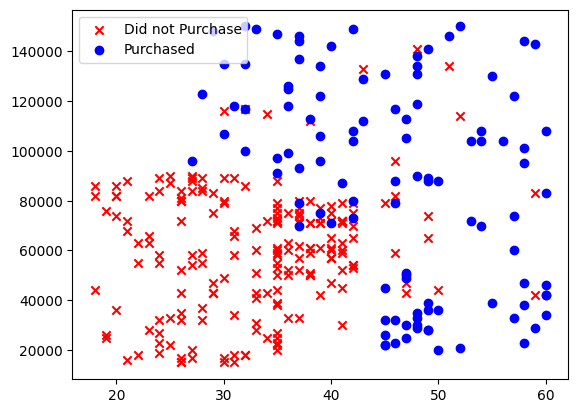

In [1049]:
plt.scatter(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], marker='x', c='r', label='Did not Purchase')
plt.scatter(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], marker='o', c='b', label='Purchased')
plt.legend()
plt.show()

## Data Visualization: Testing Data Scatter Plot

Similar to the training data, this scatter plot displays the distribution of 'Age' and 'Salary' for the test set, segregated by purchase decision. This allows us to observe if the class separation is similar in the unseen data.

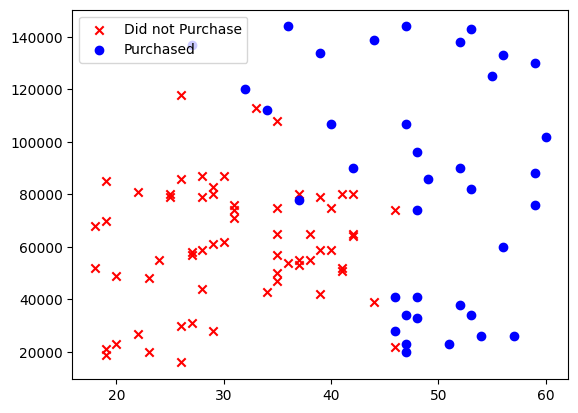

In [1050]:
plt.scatter(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], marker='x', c='r', label='Did not Purchase')
plt.scatter(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], marker='o', c='b', label='Purchased')
plt.legend()
plt.show()

## Custom Logistic Regression Model

Here, we define our custom `LogisticRegressionModel` class. This model implements logistic regression from scratch, incorporating polynomial features, feature scaling (normalization), and L2 regularization (controlled by `LAM`). It also includes methods for gradient descent, cost calculation, prediction, performance evaluation, and plotting the decision boundary and cost history.

## Model Instantiation and Training

We instantiate our custom `LogisticRegressionModel` using the training and testing datasets. The `__init__` method of the class automatically performs polynomial feature transformation, normalization, gradient descent training, and generates initial plots.

In [1051]:
class LogisticRegressionModel:
  def __init__(self, X_train_original, y_train, X_test_original, y_test):
    # Store original X_train and X_test for plotting if needed later
    self._X_train_original = X_train_original
    self._X_test_original = X_test_original

    self.y_train = y_train
    self.y_test = y_test

    # 1. Transform input data to polynomial features
    self.X_train = self._create_polynomial_features(X_train_original) # X_train now refers to polynomial features
    self.X_test = self._create_polynomial_features(X_test_original)   # X_test now refers to polynomial features

    # 2. Calculate mu and sigma based on X_train (polynomial features)
    self.mu = np.mean(self.X_train, axis=0)
    self.sigma = np.std(self.X_train, axis=0)
    self.sigma[self.sigma == 0] = 1 # Avoid division by zero

    # 3. Normalize both X_train and X_test using training data's mu and sigma
    self.X_train_norm = (self.X_train - self.mu) / self.sigma
    self.X_test_norm = (self.X_test - self.mu) / self.sigma

    self.learning_rate = 0.3
    self.max_iter = 10000
    self.m = self.X_train.shape[0] # Number of training examples
    self.weight = np.zeros(self.X_train.shape[1]) # Weight size matches number of polynomial features
    self.LAM = 0
    self.bias = 0
    self.cost_history = []
    self.final_weight = None
    self.final_bias = None
    self.gradient_descent()
    self.get_plots()

  def _create_polynomial_features(self, X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    # Assuming degree 2 polynomial features: x1, x2, x1^2, x1*x2, x2^2
    return np.column_stack([x1, x2, x1**2, x1 * x2, x2**2])

  def get_sigmoid(self):
    # Use normalized polynomial features
    z = self.X_train_norm @ self.weight + self.bias
    return 1 / (1 + np.exp(-z))

  def cost(self):
    predictions = self.get_sigmoid()
    return (-(1 / self.m) * np.sum(
            self.y_train * np.log(predictions) +
            (1 - self.y_train) * np.log(1 - predictions)
        ) + (self.LAM/2*self.m)*sum(self.weight**2) )

  def error(self):
    return self.get_sigmoid() - self.y_train

  def gradient(self):
    # Corrected dw calculation: (X_train_norm.T @ error) / m
    dw = ((1 / self.m) * self.X_train_norm.T @ self.error()) + self.LAM / self.m * self.weight
    db = np.mean(self.error())
    return dw, db

  def gradient_descent(self):
    for _ in range(self.max_iter):
      self.cost_history.append(self.cost())
      dj_dw, dj_db = self.gradient()
      self.weight = self.weight - self.learning_rate*dj_dw
      self.bias = self.bias - self.learning_rate*dj_db

  def predict_sample(self, sample):
    # First, transform the sample to polynomial features
    sample_poly = self._create_polynomial_features(np.array([sample]))
    # Then, normalize the sample using the stored mu and sigma from training data
    sample_norm = (sample_poly - self.mu) / self.sigma
    # Use the final_weight and final_bias (which are for normalized polynomial features)
    z = sample_norm @ self.final_weight + self.final_bias
    pred = 1 / (1 + np.exp(-z))
    if pred >= 0.5:
      return f"Purchased: {pred[0]}"
    return f"Did not purchase: {pred[0]}"


  def get_model_performance(self):
    # Use normalized polynomial features for predictions
    z_train = self.X_train_norm @ self.final_weight + self.final_bias
    z_pred_tr_sigmoid = 1 / (1 + np.exp(-z_train))
    train_pred = (z_pred_tr_sigmoid >= 0.5).astype(int)
    correct_train_preds = train_pred == self.y_train
    train_accuracy = sum(correct_train_preds) / len(self.y_train)

    z_test = self.X_test_norm @ self.final_weight + self.final_bias
    z_pred_te_sigmoid = 1 / (1 + np.exp(-z_test))
    test_pred = (z_pred_te_sigmoid >= 0.5).astype(int)
    correct_test_preds = test_pred == self.y_test
    test_accuracy = sum(correct_test_preds) / len(self.y_test)

    return train_accuracy, test_accuracy


  def get_plots(self):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Scatter plot uses original features
    ax[0].scatter(self._X_train_original[:, 0][self.y_train==0], self._X_train_original[:, 1][self.y_train==0], marker='x', c='r', label='Did not Purchase')
    ax[0].scatter(self._X_train_original[:, 0][self.y_train==1], self._X_train_original[:, 1][self.y_train==1], marker='o', c='b', label='Purchased')
    ax[0].set_xlabel('Age')
    ax[0].set_ylabel('Salary in dollars')

    # Set final_weight and final_bias for predictions with normalized data
    self.final_weight = self.weight
    self.final_bias = self.bias

    # For plotting a non-linear decision boundary with polynomial features, use a meshgrid
    x_min, x_max = self._X_train_original[:, 0].min() - 5, self._X_train_original[:, 0].max() + 5
    y_min, y_max = self._X_train_original[:, 1].min() - 5000, self._X_train_original[:, 1].max() + 5000
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Combine meshgrid points into a single array for transformation
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Transform and normalize grid points using the trained mu and sigma
    grid_points_poly = self._create_polynomial_features(grid_points)
    grid_points_norm = (grid_points_poly - self.mu) / self.sigma

    # Make predictions on the grid points
    Z_val = grid_points_norm @ self.final_weight + self.final_bias
    Z = (1 / (1 + np.exp(-Z_val))).reshape(xx.shape)

    # Plot the contour of the decision function
    ax[0].contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
    # Add a contour line for the decision boundary (where probability = 0.5)
    ax[0].contour(xx, yy, Z, levels=[0.5], colors='black', linestyles='--')

    ax[0].set_title('Decision Boundary (Training Data)')
    ax[0].legend()

    ax[1].plot([i for i in range(self.max_iter)], self.cost_history)
    ax[1].set_xlabel('# iterations')
    ax[1].set_ylabel('Cost')
    ax[1].set_title('Cost History')
    plt.tight_layout() # Adjust layout to prevent overlapping
    plt.show()

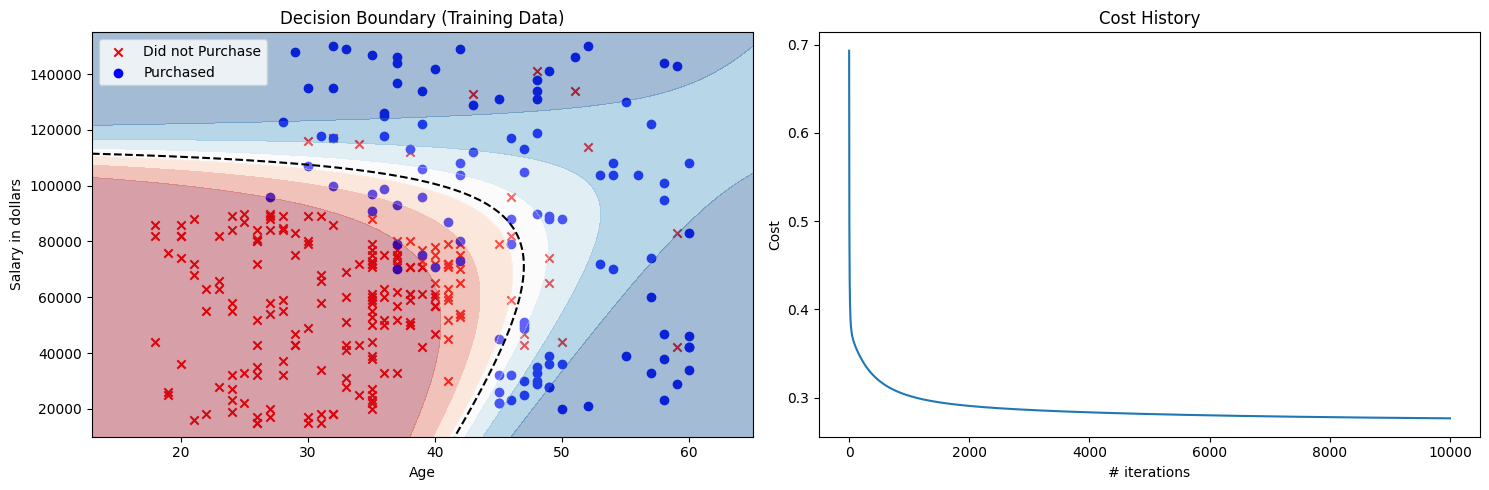

In [1052]:
model1 = LogisticRegressionModel(X_train, y_train, X_test, y_test)

## Predict for a Sample

Let's test our trained model by predicting the purchase outcome for a new sample, for example, a user with Age 40 and Salary 1.

In [1053]:
print(model1.predict_sample(np.array([40, 1])))

Did not purchase: 0.4694784523201966


## Scikit-learn Comparison: Imports

We import necessary modules from `sklearn` for comparison: `LogisticRegression` for the model, `Pipeline` to chain transformations and the model, `PolynomialFeatures` to create polynomial features, and `accuracy_score` for evaluation.

In [1054]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

## Scikit-learn Logistic Regression Model

To benchmark our custom model, we create a similar logistic regression model using `scikit-learn`. We use a `Pipeline` to first apply `PolynomialFeatures` (degree 2, matching our custom model) and then fit a `LogisticRegression` model.

In [1055]:
model2 = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('logistic', LogisticRegression(max_iter=1000))
])
model2.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures()),
                ('logistic', LogisticRegression(max_iter=1000))])

## Generate Scikit-learn Predictions

We generate predictions for both the training and testing datasets using the `scikit-learn` model to calculate its accuracy.

In [1056]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

## Model Performance Comparison

Finally, we compare the training and testing accuracy scores of our custom `LogisticRegressionModel` with the `scikit-learn` implementation. This helps us evaluate how well our custom model performs against a highly optimized library version.

In [1057]:
print("----------------------------------------------------------")
print(f"OUR MODEL:")
print(f"train accurasy score: {model1.get_model_performance()[0]}")
print(f"test accurasy score: {model1.get_model_performance()[1]}")
print("----------------------------------------------------------")
print("SCIKITLEARN-LEARN MODEL:")
print(f"train accurasy score: {accuracy_score(y_train, y_train_pred)}")
print(f"test accurasy score: {accuracy_score(y_test, y_test_pred)}")
print("----------------------------------------------------------")

----------------------------------------------------------
OUR MODEL:
train accurasy score: 0.89
test accurasy score: 0.94
----------------------------------------------------------
SCIKITLEARN-LEARN MODEL:
train accurasy score: 0.89
test accurasy score: 0.93
----------------------------------------------------------
